# Analysing mock datasets

In [21]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations

import sys
sys.path.append("../src")

from analysis import *
from inference import *

In [22]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key=alphanum_key)

In [23]:
datapath = "../experiment_outputs/test2/datasets/"
datafiles = os.listdir(datapath)
metadatafiles = [f"metadata{i.split('dataset')[1].split('csv')[0]}txt"\
                for i in datafiles]

datafiles = natural_sort(datafiles)
metadatafiles = natural_sort(metadatafiles)

In [24]:
n_sp = 10
print(f"{n_sp} species")

datafiles_n_sp = [i for i in datafiles if f"{n_sp}_sp" in i]
metadatafiles_n_sp = [i for i in metadatafiles if f"{n_sp}_sp" in i]

df = pd.read_csv(datapath+datafiles[-1], index_col=0)
metatext = open(f"{datapath}../metadata/"+metadatafiles[-1], "r").read().split("\n")

10 species


In [25]:
def get_meta(metatext):
    meta = {}
    for n, line in enumerate(metatext):
        if "initial conditions" in line:
            init_cond_ln_idx = n

        elif "sampling timepoints" in line:
            t_samp_ln_idx = n

        elif "parameters" in line:
            meta["parameters"] = np.array([np.float64(j) for j in line.split(": ")[1].split(",")])
            params_ln_idx = n
        
        elif "measurement noise" in line:
            meta["meas_noise"] = np.array([np.float64(j) for j in line.split(": ")[1].split(",")])
            meas_noise_ln_idx = n
            break

    meta["init_cond"] = np.array([[np.float64(i) for i in metatext[j].split(",")] \
                                  for j in range(init_cond_ln_idx+1, t_samp_ln_idx)])

    meta["n_init_cond"] = len(meta["init_cond"])

    meta["t_samp"] = [np.array([np.float64(i) for i in metatext[j].split(",")]) \
                                  for j in range(t_samp_ln_idx+1, params_ln_idx)]

    meta["n_tpoints"] = np.array([len(t) for t in meta["t_samp"]])

    meta["avg_dt"] = np.array([np.diff(t).mean() for t in meta["t_samp"]])

    for i in range(meas_noise_ln_idx+1, len(metatext)-1):
        key, val = metatext[i].split(": ")
        meta[key] = np.float64(val)

    key, val = metatext[-1].split(": ")
    meta[key] = bool(val)

    meta["repetitions"] = int(meta["repetitions"])

    return meta

In [26]:
metadict = get_meta(metatext)

print(f"Numbers of sampling points: {metadict['n_tpoints']}")
print(f"Average sampling intervals: {metadict['avg_dt'].round(3)}")
print(f"Number of initial conditions: {metadict['n_init_cond']}")
print(f"Number of repetitions: {metadict['repetitions']}")
print(f"Environmental noise: {metadict['env_noise']}")
print(f"Amounts of measurement noise: {metadict['meas_noise']}")

Numbers of sampling points: [11 21 31]
Average sampling intervals: [3.  1.5 1. ]
Number of initial conditions: 20
Number of repetitions: 1
Environmental noise: 0.1
Amounts of measurement noise: [0.1]


In [27]:
def calculate_es_score(true_aij, inferred_aij) -> float:
    """GRANT'S edited version to calculate ED score

    Calculate the ecological direction (EDₙ) score (n := number of species in ecosystem).

    Parameters
    ===============
    truth: ndarray(axis0=species_names, axis1=species_names), the ecosystem coefficient matrix used to generate data
    inferred: ndarray(axis0=species_names, axis1=species_names), the inferred ecosystem coefficient matrix
    Returns
    ===============
    ES_score: float
    """

    truth = pd.DataFrame(true_aij).copy()
    inferred = pd.DataFrame(inferred_aij).copy()

    # consider inferred coefficients
    mask = inferred != 0

    # compare sign: agreement when == -2 or +2, disagreement when 0
    nonzero_sign = np.sign(inferred)[mask] + np.sign(truth)[mask]
    corr_sign = (np.abs(nonzero_sign) == 2).sum().sum()
    opposite_sign = (np.abs(nonzero_sign) == 0).sum().sum()

    # count incorrect non-zero coefficients
    wrong_nz = (truth[mask] == 0).sum().sum()

    # combine
    unscaled_score = corr_sign - opposite_sign

    # scale by theoretical extrema
    truth_nz_counts = (truth != 0).sum().sum()
    truth_z_counts = len(truth.index) ** 2 - truth_nz_counts
    theoretical_min = -truth_nz_counts
    theoretical_max = truth_nz_counts

    ES_score = (unscaled_score - theoretical_min) / (theoretical_max - theoretical_min)

    return ES_score

In [35]:
# Infer and score

try:
    os.mkdir(f"{datapath}/../inference")
except:
    pass

param_columns = [f"r{i}" for i in range(1, n_sp+1)] + \
                [f"A{i},{j}" for i in range(1, n_sp+1) for j in range(1, n_sp+1)]

cols = ["n_init_cond"] + list(df.columns[1:4]) + param_columns + ["MSPD", "CSR", "ES"]
infer_out_all = []

for file_idx in range(len(datafiles_n_sp)):
    datafile = datafiles_n_sp[file_idx]
    metadatafile = metadatafiles_n_sp[file_idx]

    df = pd.read_csv(datapath+datafile, index_col=0)
    metatext = open(f"{datapath}../metadata/"+metadatafile, "r").read().split("\n")
    metadict = get_meta(metatext)
    
    infer_out = pd.DataFrame(columns=cols)

    pd.options.mode.chained_assignment = None

    p = metadict["parameters"]
    r = p[:n_sp]
    A = p[n_sp:].reshape((n_sp,n_sp))

    for t_samp in df.t_samp_dist_idx.unique():
        for meas_noise in df.measurement_noise.unique():
            df_tmp = df[(df[["t_samp_dist_idx", "measurement_noise"]]==[t_samp, meas_noise]).all(axis=1)]
            for i in tqdm(range(len(df.init_cond_idx.unique()))):
                combs = list(combinations(df.init_cond_idx.unique(), i+1))
                np.random.shuffle(combs)
                for comb in combs[:100]:
                    df_comb = df_tmp[df_tmp.init_cond_idx.isin(comb)]
                    r_est, A_est = fit_ridge_cv(df_comb)
                    p_est = np.concatenate((r_est, A_est.flatten()))
                    MSPD = ((p-p_est)**2).mean()
                    CSR = (np.sign(A_est)==np.sign(A)).mean()
                    ES = calculate_es_score(A, A_est)
                    infer_out.loc[len(infer_out)] = [i+1, comb, t_samp, meas_noise] + list(p_est) + [MSPD, CSR, ES]


    infer_out.to_csv(f"{datapath}/../inference/infer_out_"+datafile.split("dataset")[1])
    infer_out_all.append(infer_out)

100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


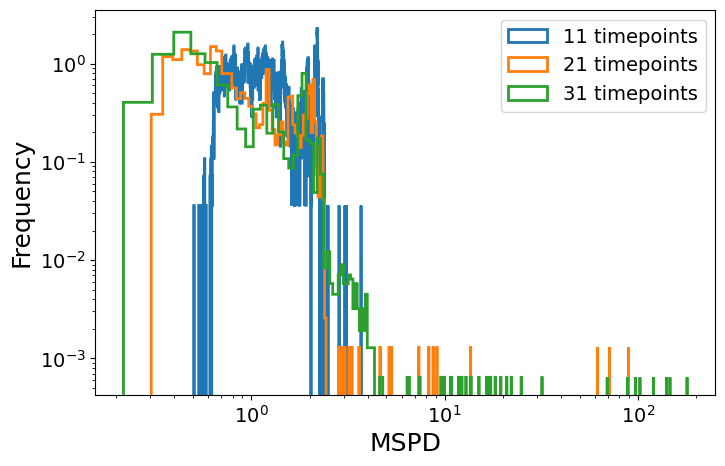

In [58]:
# MSPD frequency
plt.figure(figsize=(8,5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].MSPD.values, 2000,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints", 
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show()

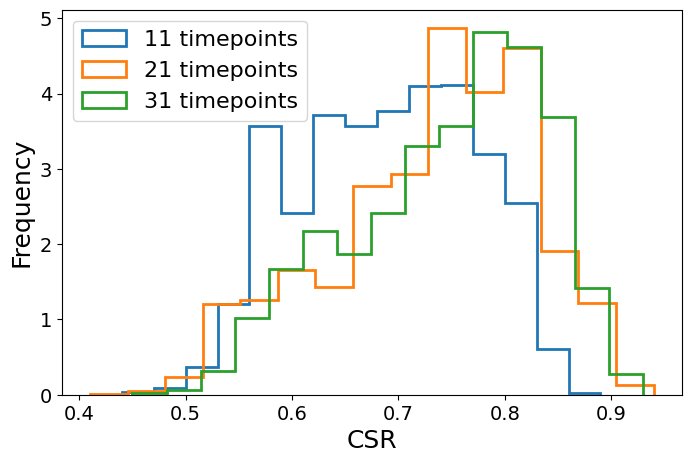

In [62]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].CSR.values, 15,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

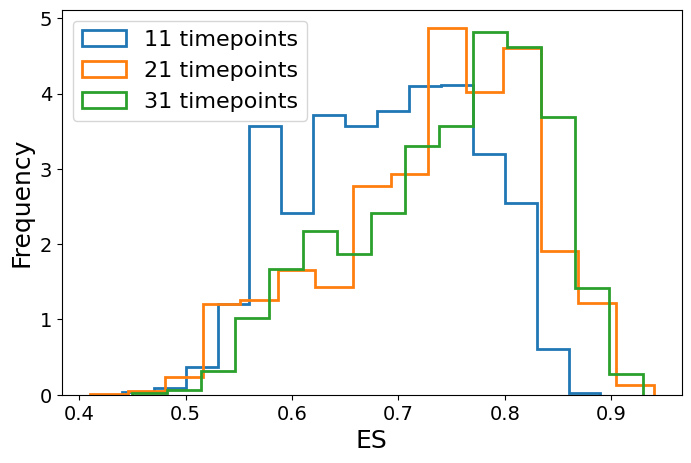

In [61]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].ES.values, 15,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [59]:
# Difference between CSR and ES scores
(infer_out_all.CSR!=infer_out_all.ES).sum()

0

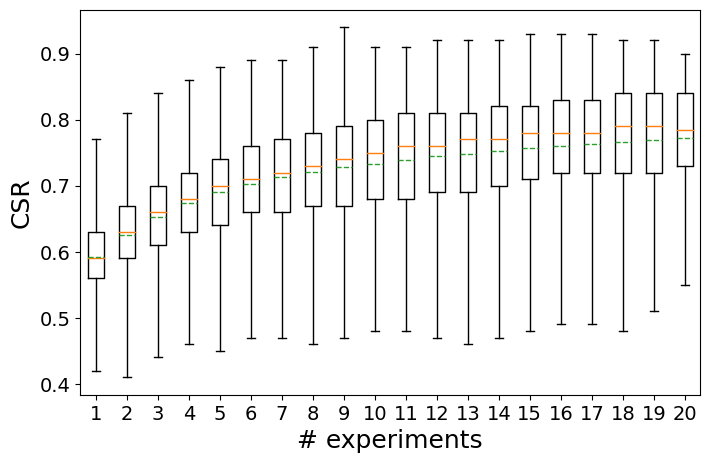

In [106]:
# CSR boxplots over # of experiments
CSR = [infer_out_all[infer_out_all.n_init_cond==i]["CSR"].values \
        for i in infer_out_all.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

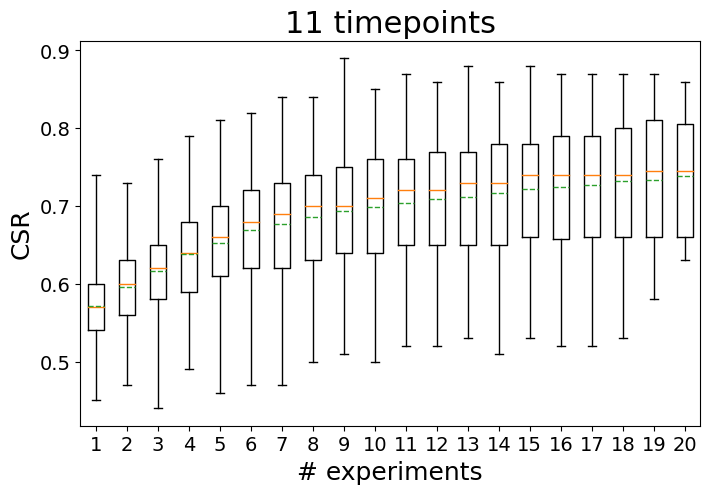

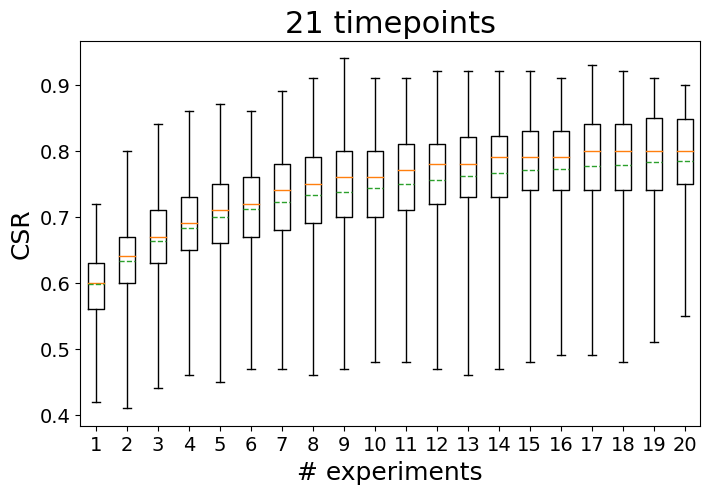

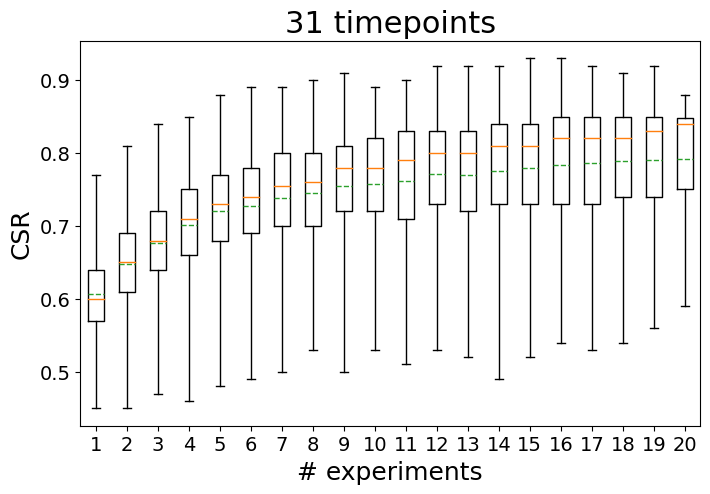

In [63]:
# CSR boxplot over # of experiments, by n_tpoints
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    CSR = [infer_out_all[(infer_out_all[["n_init_cond", "t_samp_dist_idx"]]==[i,t_samp]).all(axis=1)]["CSR"].values \
            for i in infer_out_all.n_init_cond.unique()]

    plt.figure(figsize=(8,5))
    plt.title(f"{metadict['n_tpoints'][int(t_samp)]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

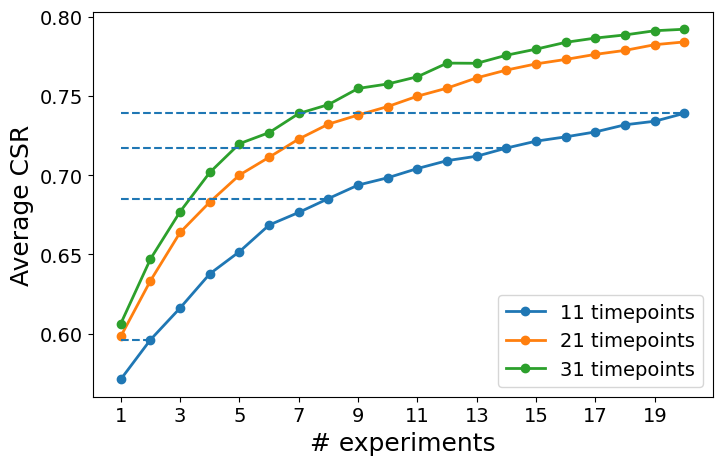

In [99]:
# average CSR over time
avgCSR = np.zeros((len(metadict["t_samp"]), len(metadict["init_cond"])))
for i in range(len(infer_out_all.t_samp_dist_idx.unique())):
    t_samp = infer_out_all.t_samp_dist_idx.unique()[i]
    for j in range(len(infer_out_all.n_init_cond.unique())):
        n_init_cond = infer_out_all.n_init_cond.unique()[j]
        avgCSR[i,j] = infer_out_all[(infer_out_all[["t_samp_dist_idx", "n_init_cond"]]==[t_samp, n_init_cond]).all(axis=1)]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in metadict["n_tpoints"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.show()

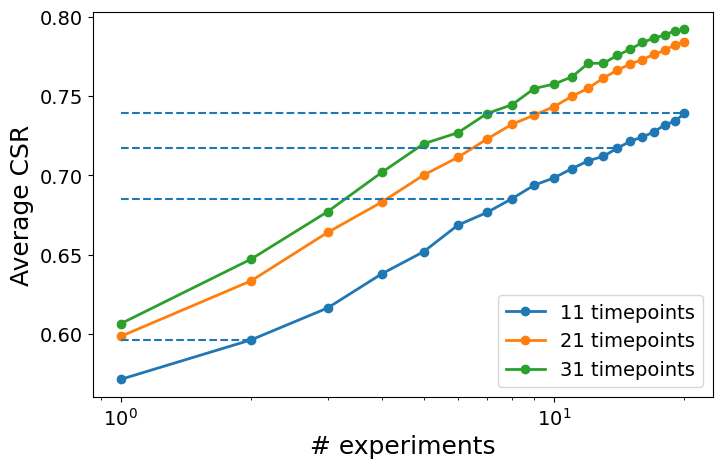

In [100]:
# average CSR over time
avgCSR = np.zeros((len(metadict["t_samp"]), len(metadict["init_cond"])))
for i in range(len(infer_out_all.t_samp_dist_idx.unique())):
    t_samp = infer_out_all.t_samp_dist_idx.unique()[i]
    for j in range(len(infer_out_all.n_init_cond.unique())):
        n_init_cond = infer_out_all.n_init_cond.unique()[j]
        avgCSR[i,j] = infer_out_all[(infer_out_all[["t_samp_dist_idx", "n_init_cond"]]==[t_samp, n_init_cond]).all(axis=1)]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in metadict["n_tpoints"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.xscale("log")
plt.show()

In [101]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1,j]/avgCSR[0,i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2,j]/avgCSR[0,i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2,j]/avgCSR[1,i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))

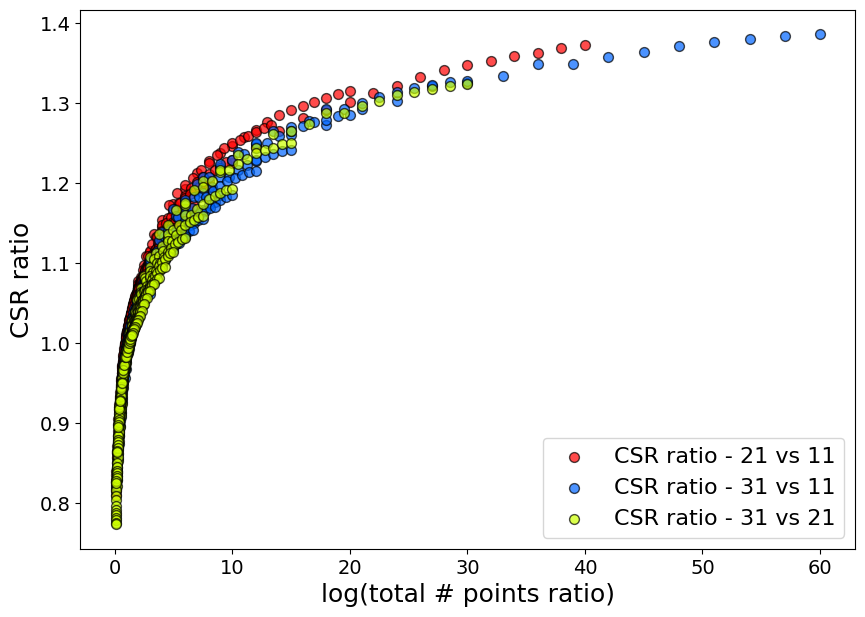

In [96]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

#12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9916518874400488
intercept = 1.00432, slope = 0.09702

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9876937534511693
intercept = 0.98361, slope = 0.09685

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9848630581268115
intercept = 0.98528, slope = 0.09205

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9805433541976535
intercept = 0.99166, slope = 0.09522


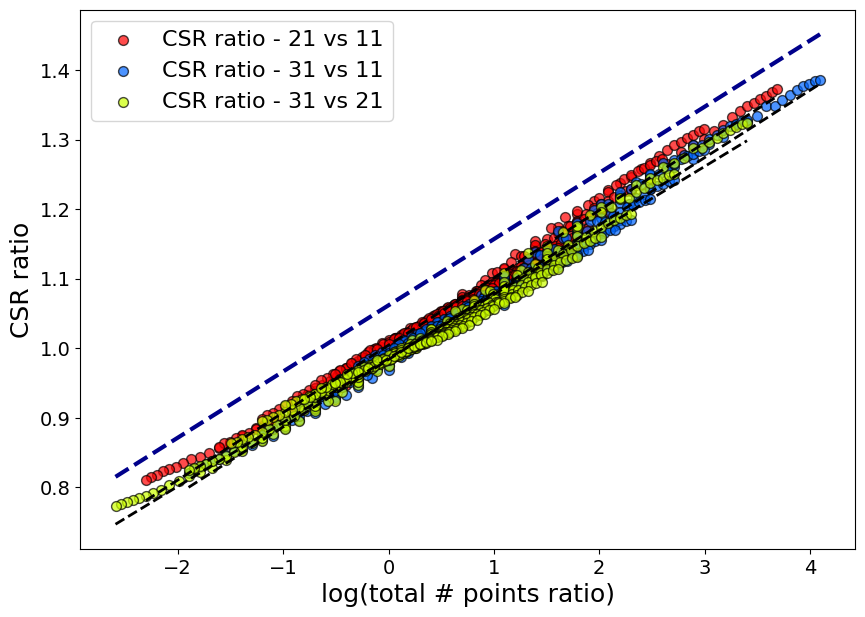

In [97]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9948688314872425
intercept = 0.00104, slope = 0.09075

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9902905977888099
intercept = -0.01674, slope = 0.08912

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9908619046695408
intercept = -0.01927, slope = 0.09001

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9843304921571405
intercept = -0.01173, slope = 0.08990


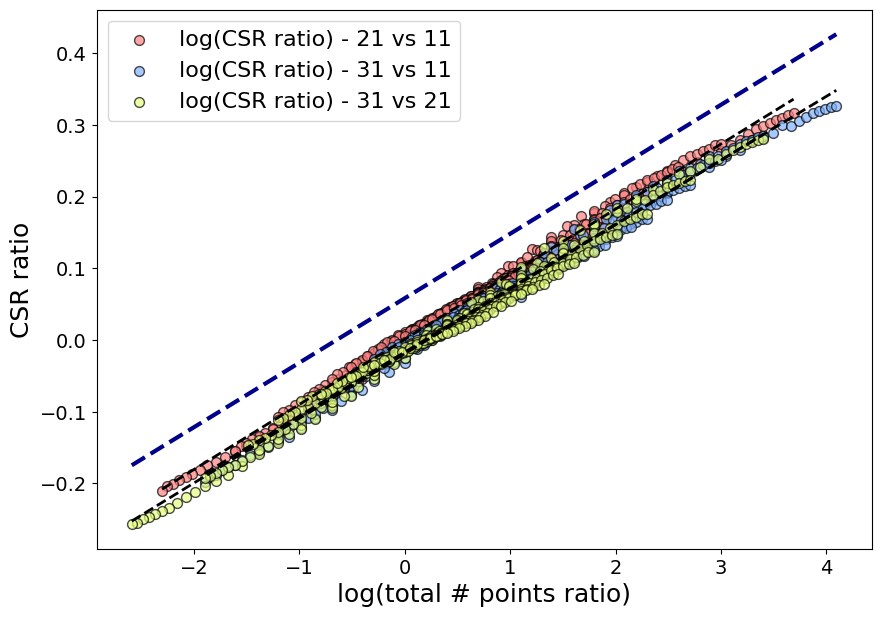

In [98]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

R2 score = 0.6095945570378805


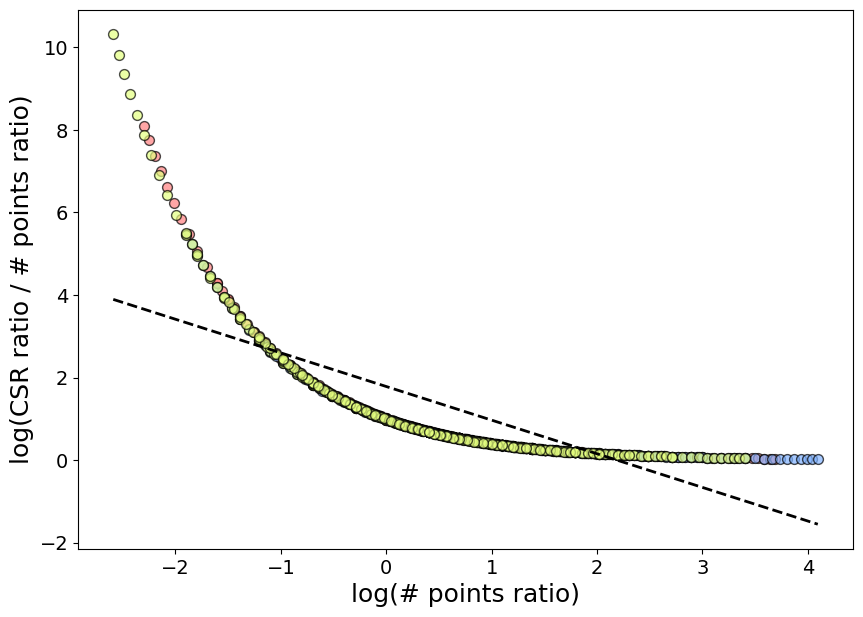

In [49]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01, 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02, 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12, 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

R2 score = 0.9998446928139265


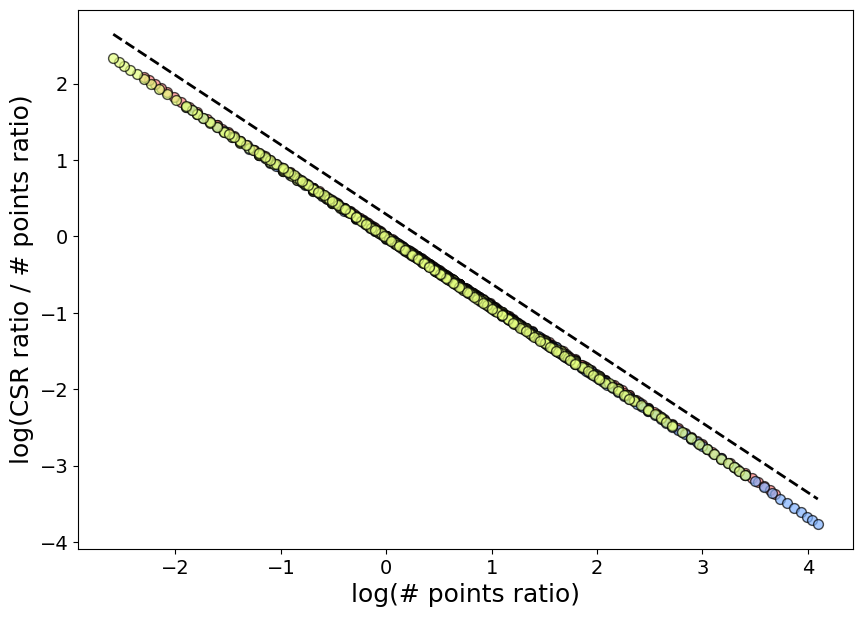

In [50]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01), 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02), 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12), 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

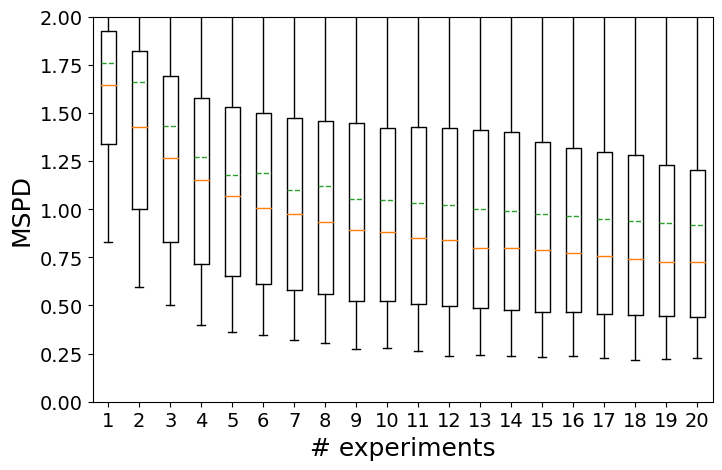

In [51]:
# MSPD boxplots over # of experiments

MSPD = [infer_out_all[infer_out_all.n_init_cond==i]["MSPD"].values \
        for i in infer_out_all.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(MSPD, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("MSPD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale("log")
plt.ylim(0, 2)
plt.show()